In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, timezone
import yfinance as yf 
from scipy.optimize import minimize 
import seaborn as sns
from scipy import stats


In [9]:
Seans_Tickers = [

    'NLR', 'URA','RSP','VOO','QQQ'

]
end_date = datetime.now()
start_date = end_date - timedelta(days = 2 * 365)
print (start_date)
print (end_date)


2023-03-25 22:11:18.800883
2025-03-24 22:11:18.800883


In [10]:
df = yf.download(Seans_Tickers, start=start_date, end=end_date)

[*********************100%***********************]  5 of 5 completed

5 Failed downloads:
['URA', 'NLR', 'RSP', 'VOO', 'QQQ']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


make a subset by the close and valumne columns 

In [11]:
df = df.loc[:, ['Close', 'Volume']]
df = df.sort_index()

creating a multi level column sutrcture for ROR 

In [12]:
pct = df['Close'].pct_change()

pct.columns = pd.MultiIndex.from_product([['RoR'], pct.columns])

Concatenating the new RoR DataFrame with the original 

In [13]:
df1 = pd.concat([df, pct], axis=1)
df1.dropna(inplace=True)
print(df1)

Empty DataFrame
Columns: [(Close, NLR), (Close, QQQ), (Close, RSP), (Close, URA), (Close, VOO), (Volume, NLR), (Volume, QQQ), (Volume, RSP), (Volume, URA), (Volume, VOO), (RoR, NLR), (RoR, QQQ), (RoR, RSP), (RoR, URA), (RoR, VOO)]
Index: []


Lets look at Calculating Cumulatlive Returns 
1st)calculate total returns for each stock 
2nd)Plot returns 

In [14]:
cum_returns = (df1['Close'] / df1['Close'].iloc[0])
print(cum_returns)
cum_returns.plot(figsize=(10, 7))
plt.title('Cumulative Returns')
plt.legend(loc='upper left')
plt.show()

IndexError: single positional indexer is out-of-bounds

Calculate the mean, std deviation and mean/std deviation ratio annualized (252 TRADING DAYS IN A YEAR)

In [335]:
RoR = df1['RoR'] 

In [336]:
mean_vals = RoR.mean() * 252
std_vals = RoR.std() * np.sqrt(252)
ratio_vals = mean_vals / std_vals


Create a figure and a set of subplots (2 plots)

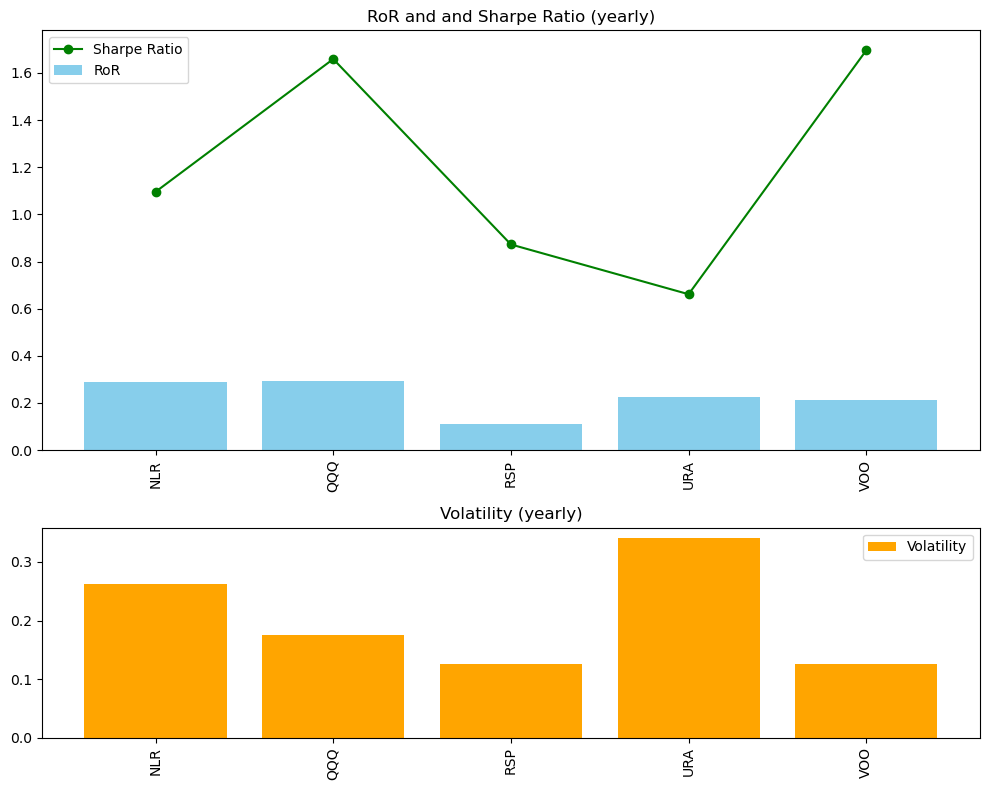

In [337]:
RoR = df1['RoR']
# Calculate the mean, std, and mean/std ratio (yearly)
mean_vals = RoR.mean() * 252
std_vals = RoR.std() * np.sqrt(252)
ratio_vals = mean_vals / std_vals
# Create a figure and a set of subplots (2 plots)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),
                               gridspec_kw={'height_ratios':
                                            [2, 1]})
# Plotting mean values as a bar plot in the first subplot
ax1.set_title('RoR and and Sharpe Ratio (yearly)')
ax1.bar(mean_vals.index, mean_vals, color='skyblue', label='RoR')
# Plotting mean/std ratio as a line plot on the same axes
ax1.plot(ratio_vals.index, ratio_vals, color='green',
         marker='o', linestyle='-', label='Sharpe Ratio')
# Rotate x-axis labels for the first subplot
ax1.tick_params(axis='x', rotation=90)
ax1.legend()
# Plotting std values as a bar plot in the second subplot
ax2.set_title('Volatility (yearly)')
ax2.bar(std_vals.index, std_vals,
        color='orange', label='Volatility')
# Rotate x-axis labels for the second subplot
ax2.tick_params(axis='x', rotation=90)
ax2.legend()
# Adjusting layout and showing the plot
plt.tight_layout()
plt.show()


The following code is to assess the core financial metrics related to the following asssets (asset proportions are based on randum number generation) 

In [338]:
def calculate_portfolio_metrics (df, w):
    # Calculate the log returns 
    log_RoR = (df/df.shift(1)).apply(np.log).dropna()
    # Calculate the portfolio return
    portfolio_return = np.sum(log_RoR.mean() * w) * 252
    #calculate the std devation of the portfolio(two ways to do it)
    
    sd1 = (log_RoR*w).sum(axis=1).std() * np.sqrt(252)
    sd2 = np.sqrt(np.dot(w.T, np.dot(log_RoR.cov() * 252, w)))


    # Calculate the Sharpe ratio
    sharpe_ratio = portfolio_return / sd2
    
    return (portfolio_return, sd1,sd2, sharpe_ratio)
#########################################################################################
w = np.random.random(len(df1['Close'].columns))
w /= np.sum(w)
addition_of_weights = sum(w)
print(f"addition_of_weights: {addition_of_weights}")
print(f"Initial Weights: {w}")
pm = calculate_portfolio_metrics(df1['Close'], w)
print("Optimization")

print(f"Portfolio Return: {pm[0]:.2f}")
print(f"Portfolio Volatility: {pm[1]:.2f}")
print(f"Sharpe Ratio: {pm[2]:.2f}") 





 


addition_of_weights: 0.9999999999999999
Initial Weights: [0.18229453 0.21287067 0.22997427 0.22134851 0.15351202]
Optimization
Portfolio Return: 0.20
Portfolio Volatility: 0.17
Sharpe Ratio: 0.17


Monte carlo 2000 simulations

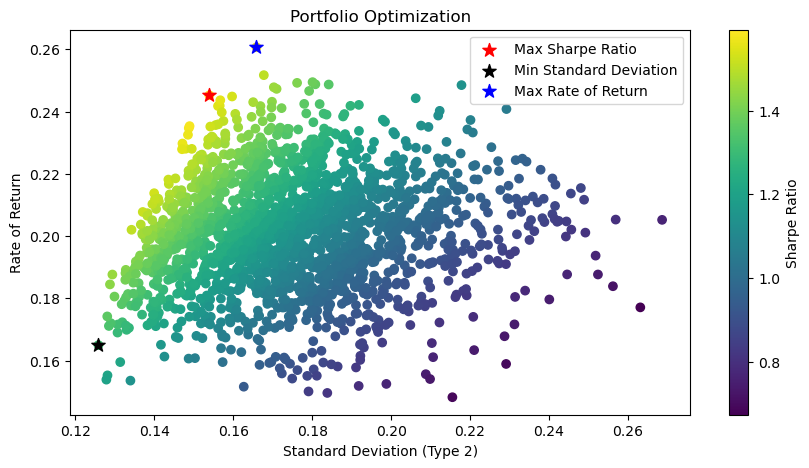

In [339]:
# Number of simulations to run
simulation_numbers = 2000
# Define the tickers for the portfolio
portfolio_tickers = ['NLR', 'URA', 'RSP', 'VOO', 'QQQ']
# Generate random weights for all simulations
weights = np.random.random((simulation_numbers,
                            len(portfolio_tickers)))
weights /= weights.sum(axis=1)[:, np.newaxis]
# Initialize arrays to store the results of the simulations
RoR_arr = np.zeros(simulation_numbers) 
sd1_arr = np.zeros(simulation_numbers)
sd2_arr = np.zeros(simulation_numbers)
sharpe_arr = np.zeros(simulation_numbers)
# Run simulations to calculate portfolio metrics
for i in range(simulation_numbers):
    # Current set of weights
    w = weights[i] 
    # Calculate portfolio metrics for the current weights
    portfolio_assets = df['Close'][portfolio_tickers]
    m = calculate_portfolio_metrics(portfolio_assets, w)
    RoR_arr[i], sd1_arr[i], sd2_arr[i], sharpe_arr[i] = \
        m[0], m[1], m[2], m[3]
# Create a DataFrame to store the simulation results
portfolio_results = pd.DataFrame({
    'Weights': list(weights),
    'Rate of Return': RoR_arr,
    'Standard Deviation (Type 1)': sd1_arr,
    'Standard Deviation (Type 2)': sd2_arr,
    'Sharpe Ratio': sharpe_arr
})
# Scatter plot of the simulation results
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_results['Standard Deviation (Type 2)'],
            portfolio_results['Rate of Return'],
            c=portfolio_results['Sharpe Ratio'],
            cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation (Type 2)')
plt.ylabel('Rate of Return')
# Find the key points of the portfolios
# Index of the portfolio with the max Sharpe Ratio
max_sharpe_idx = portfolio_results['Sharpe Ratio'].idxmax()  
# Index of the portfolio with the min Standard Deviation
min_std_idx = portfolio_results['Standard Deviation (Type 2)'].idxmin()  
# Index of the portfolio with the max Rate of Return
max_ror_idx = portfolio_results['Rate of Return'].idxmax()
# Highlight key points in the scatter plot
plt.scatter(portfolio_results.loc[max_sharpe_idx,
                                  'Standard Deviation (Type 2)'],
            portfolio_results.loc[max_sharpe_idx, 'Rate of Return'],
            color='red', marker='*', s=100,
            label='Max Sharpe Ratio')
plt.scatter(portfolio_results.loc[min_std_idx,
                                  'Standard Deviation (Type 2)'],
            portfolio_results.loc[min_std_idx, 'Rate of Return'],
            color='black', marker='*', s=100,
            label='Min Standard Deviation')
plt.scatter(portfolio_results.loc[max_ror_idx,
                                  'Standard Deviation (Type 2)'],
            portfolio_results.loc[max_ror_idx,
                                  'Rate of Return'],
            color='blue', marker='*', s=100,
            label='Max Rate of Return')
plt.legend()
plt.title('Portfolio Optimization')
plt.show()


Scipy minimiazation functions, analyze and compare 

In [340]:
#function to calculate portfolio returns 
def portfolio_return(weirghts, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

#function to calculate portfolio volatility
def portfolio_volatility(weights, log_returns):
    return np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))



[*********************100%***********************]  1 of 1 completed


Price             Close      High       Low      Open    Volume
Ticker              NLR       NLR       NLR       NLR       NLR
Price  Ticker                                                  
Close  NLR     1.000000  0.998788  0.998760  0.996612  0.589411
High   NLR     0.998788  1.000000  0.998671  0.998638  0.596821
Low    NLR     0.998760  0.998671  1.000000  0.998443  0.579650
Open   NLR     0.996612  0.998638  0.998443  1.000000  0.590977
Volume NLR     0.589411  0.596821  0.579650  0.590977  1.000000


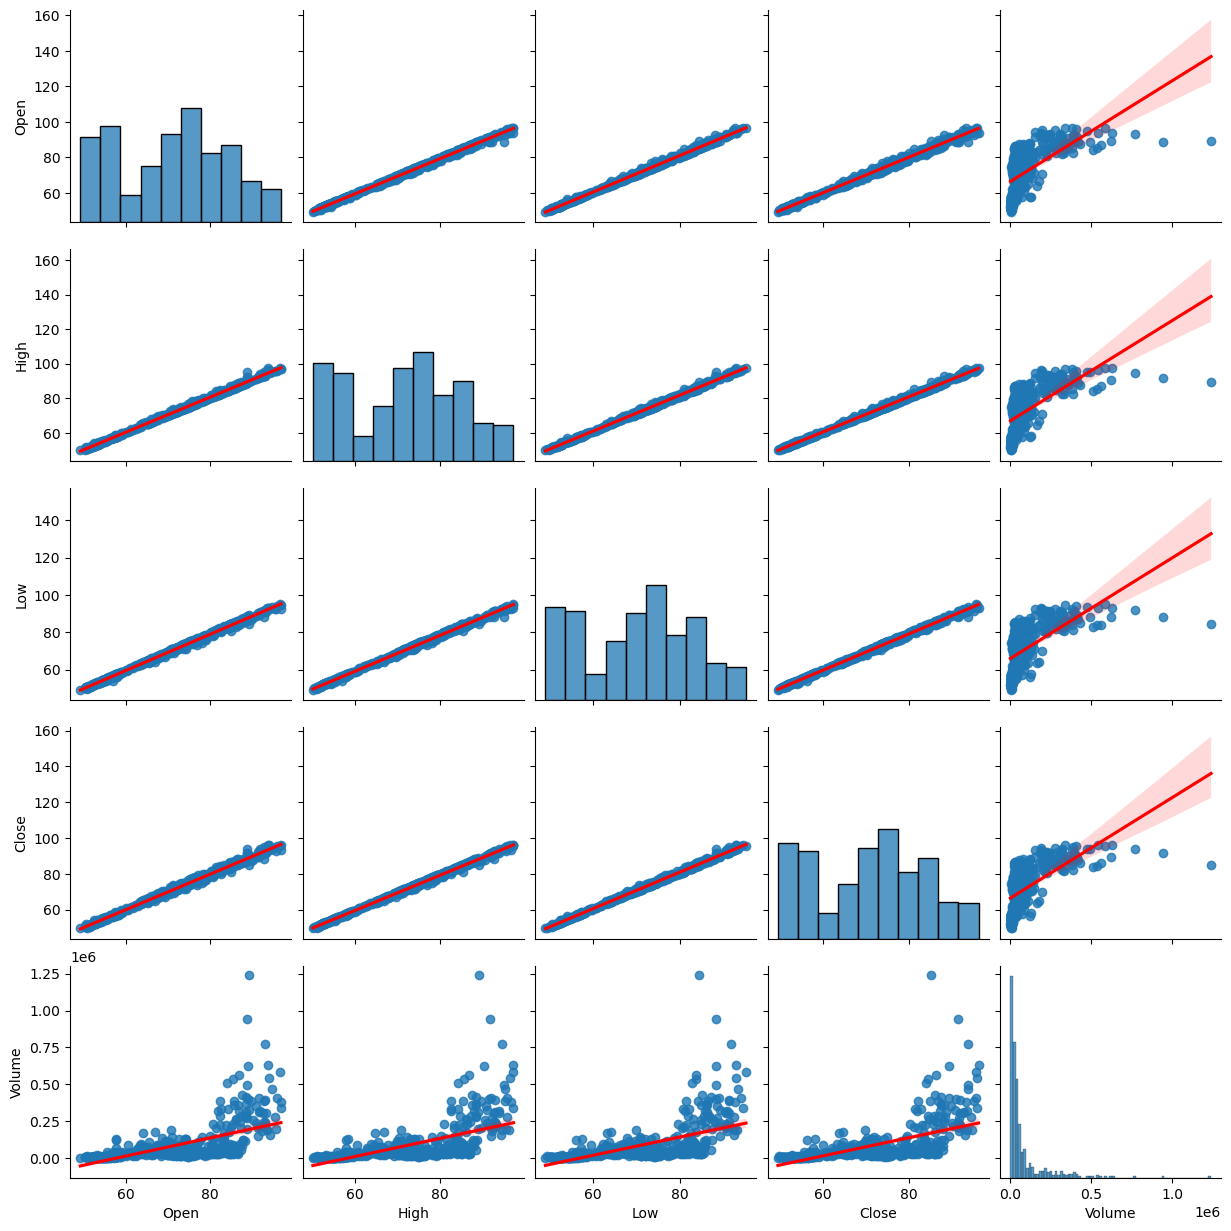

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.319e+05
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        00:12:28   Log-Likelihood:                -232.93
No. Observations:                 500   AIC:                             475.9
Df Residuals:                     495   BIC:                             496.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0413      0.117     -0.352      0.7

In [341]:
import statsmodels.api as sm
reg_data = yf.download('NLR', start=start_date, end=end_date)
##Calculate correlation matrix 
corr_matrix = reg_data.corr()
print(corr_matrix)
### pairplot with regresssion lines 
sns.pairplot(reg_data.xs('NLR', level='Ticker', axis=1)[['Open', 'High', 'Low', 'Close', 'Volume']],
             kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

##define the dependent and independent variables
X = reg_data.xs('NLR', level='Ticker', axis=1)[['Open', 'High', 'Low', 'Volume']]
y = reg_data.xs('NLR', level='Ticker', axis=1)['Close']
##add constant to the independent variables
X = sm.add_constant(X) ## the sm is the statsmodels library and we are adding a constant to the independent variables
### create an ols model
model = sm.OLS(y, X).fit()
print(model.summary())

In [353]:
##plot the residuals

Q = reg_data['Close']
W = reg_data['Open']
###perform linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(Q, W)
print(f"Slope: {slope}")    
print(f"Intercept: {intercept}")
print(f"R-value: {r_value}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")


ValueError: too many values to unpack (expected 4)